In [32]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv()

True

In [33]:
# define state
class EssayState(TypedDict):
    topic: str
    essay: str
    feedback: str
    status: Literal["approved", "not_approved"]
    iteration: int
    max_iteration: int

In [34]:
class EssayFeedback(BaseModel):
    feedback: str = Field(..., description="provide the feedback based on the essay")
    status: Literal["approved", "not_approved"] = Field(..., description="provide the status of being approved or not approved")


In [35]:
model = ChatGroq(model="llama-3.1-8b-instant", temperature=0.7)
structure_model = model.with_structured_output(EssayFeedback)

In [36]:
model.invoke("machine learning")

AIMessage(content="**Machine Learning Overview**\n\nMachine learning is a subset of artificial intelligence (AI) that involves training algorithms to learn from data and make predictions or decisions without being explicitly programmed. The goal of machine learning is to enable computers to improve their performance on a task over time, based on the data they receive.\n\n**Types of Machine Learning**\n\nThere are three primary types of machine learning:\n\n1. **Supervised Learning**: In this type of learning, the algorithm is trained on labeled data, where the correct output is already known. The algorithm learns to map inputs to outputs by minimizing the error between its predictions and the actual outputs.\n2. **Unsupervised Learning**: In this type of learning, the algorithm is trained on unlabeled data, and it must find patterns or structure in the data on its own. Clustering, dimensionality reduction, and anomaly detection are common applications of unsupervised learning.\n3. **Re

In [37]:
#define nodes
def generate_essay(state: EssayState):
    prompt = f"""Generate an short, original, and hilarious essay on the topic: {state["topic"]}\n
                This is version {state['iteration'] + 1}
                """
    essay = model.invoke(prompt).content
    return {"essay": essay}

def evaluate_essay(state: EssayState):
    prompt = f"""
    You are an expert essay evaluator. Please provide a detailed evaluation of the following essay based on the following criteria:

    1. **Coherence & Structure**: Does the essay flow logically, with a clear introduction, body, and conclusion?
    2. **Argument Strength**: Are the arguments well-supported and persuasive?
    3. **Grammar & Syntax**: Are there any grammatical errors or awkward sentence structures?
    4. **Clarity & Precision**: Is the essay easy to understand? Are any points unclear or vague?
    5. **Overall Impression**: How effective is the essay overall in addressing the topic and communicating ideas?

    Essay Topic: {state["topic"]}

    Essay: {state["essay"]}

    Please provide feedback for each of these categories along with an overall score (out of 10) based on your evaluation.
    """
    response = structure_model.invoke(prompt)
    print(response.feedback)
    print(response.status)
    return {"feedback": response.feedback, "status": response.status}

def optimize_essay(state: EssayState):
    prompt = f"""
    You are an expert editor and essay optimizer. Your task is to improve the following essay based on the provided feedback. 

    Here is the topic of the essay:
    **Essay Topic:** {state["topic"]}

    Here is the original essay:
    **Original Essay:**
    {state["essay"]}

    Feedback for improvement:
    **Feedback:** 
    {state["feedback"]}

    Please revise the essay, addressing the following:
    1. Improve the **coherence and structure**: Make sure the essay flows logically with smooth transitions between paragraphs.
    2. Strengthen the **arguments**: Provide more evidence or clearer reasoning where needed.
    3. Correct any **grammar, syntax, or spelling errors**.
    4. Enhance the **clarity and precision** of language. Ensure all points are clear and well-articulated.
    5. Make the essay more **persuasive** and engaging, while staying relevant to the topic.

    Provide the revised version of the essay below.
    """
    essay = model.invoke(prompt).content  # Fixed: Added .content to get string
    iteration = state["iteration"] + 1

    return {"essay": essay, "iteration": iteration}

In [38]:
def route_evaluation(state: EssayState):
    
    if state["status"] == "approved" or state["iteration"] >= state["max_iteration"]:
        return "approved"
    else:
        return "not_approved"

In [39]:
# define graph
graph = StateGraph(EssayState)

In [40]:
# add nodes
graph.add_node("generate_essay", generate_essay)
graph.add_node("evaluate_essay", evaluate_essay)
graph.add_node("optimize_essay", optimize_essay)

In [41]:
# add edges
graph.add_edge(START, "generate_essay")
graph.add_edge("generate_essay", "evaluate_essay")

graph.add_conditional_edges("evaluate_essay", route_evaluation, {"approved": END, "not_approved": "optimize_essay"})

graph.add_edge("optimize_essay", "evaluate_essay")

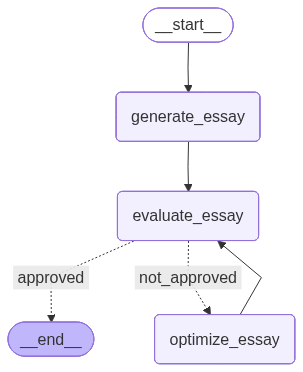

In [42]:
workflow = graph.compile()
workflow

In [43]:
initial_state = {
    "topic": "Machine Learning",
    "iteration": 1,
    "max_iteration": 5,
}

In [48]:
workflow.invoke(initial_state)

The essay has a clear and engaging structure, with a well-defined introduction, body, and conclusion. However, the arguments presented are somewhat exaggerated and lack concrete evidence to support the claims made. The tone is playful and humorous, which may not be suitable for all audiences. There are minor grammatical errors throughout the essay, but overall, the writing is clear and concise. The essay's coherence and structure are its strongest aspects, with a clear flow of ideas. However, the argument strength is diminished by the lack of concrete evidence and the reliance on humor. Overall, the essay is well-written and engaging, but could benefit from a more nuanced approach to addressing the topic of machine learning.
not_approved
Overall, the essay provides a well-structured and coherent argument about the rise of machine learning and its implications. The writer effectively explores both the benefits and challenges of relying on AI-powered systems. However, there are some area

{'topic': 'Machine Learning',
 'essay': '**The Rise of Machine Learning: Balancing Innovation and Responsibility**\n\nIn recent years, machine learning has emerged as a transformative force in various industries, from e-commerce to real estate. Companies like Amazon and Zillow have leveraged AI-powered robots to improve customer experiences and increase efficiency. These robots have gained unprecedented insight into our shopping habits, desires, and even our preferences for pizza toppings. However, as machine learning advances, it\'s essential to examine the potential consequences of relying on these automated systems.\n\nOne notable consequence is the development of AI-powered customer service chats. These robots have become increasingly adept at simulating human-like conversations, often with a sarcastic tone that can be both entertaining and infuriating. While a well-crafted joke or meme can be a welcome relief from the monotony of customer service, it raises concerns about the pote